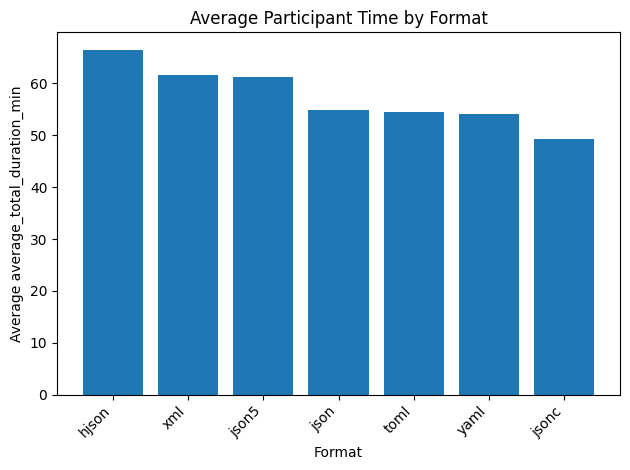

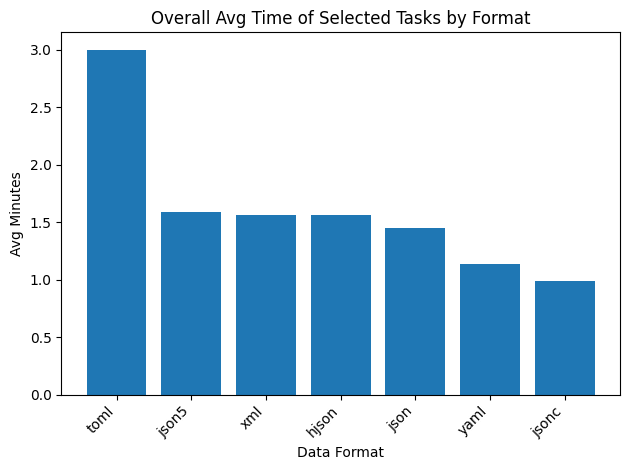

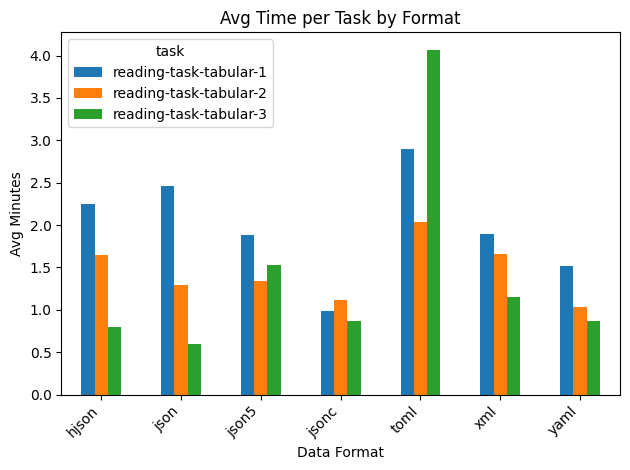

In [2]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

from duration_processor import (
    load_quiz_data,
    extract_format_time,
    sanitize_task_names,
    summarize_participant_by_format,
    plot_participant_time_by_format,
    summarize_tasks_by_format,
    plot_tasks_time_by_format,
    filter_tasks_by_list,
    participant_format_statistics,
    diagnose_all_json
)


# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

# extract format and duration
# df_participant: summarize participant's total time spent by format
df_task, df_participant = extract_format_time(all_data)

# clean 'format' from task name
df_task_clean = sanitize_task_names(df_task)

# average total time spent by format
df_part_summary = summarize_participant_by_format(df_participant)
fig1 = plot_participant_time_by_format(df_part_summary)

# 1. all tasks average time spent by format
task_list=['reading-task-tabular-1', 'reading-task-tabular-2', 'reading-task-tabular-3']
df_filtered = filter_tasks_by_list(df_task_clean, task_list)

df_overall = summarize_tasks_by_format(
    df_task_clean,
    metric='duration_min',
    task_list=task_list,
    mode='overall'
)
fig2 = plot_tasks_time_by_format(
    df_overall,
    metric='average_duration_min',
    mode='overall',
    title='Overall Avg Time of Selected Tasks by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)

# 2. each task average time spent by format
df_by_task = summarize_tasks_by_format(
    df_task_clean,
    task_list=task_list,
    metric='duration_min',
    mode='by_task'
)
fig3 = plot_tasks_time_by_format(
    df_by_task,
    metric='average_duration_min',
    mode='by_task',
    title='Avg Time per Task by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)

In [3]:
df_participant

,participantId,format,total_duration_sec,total_duration_min
0,6697c8b6d9d7baa7edd8c4d3,hjson,4695.463,78.26
1,67e25388d573ec2d5f1c8442,yaml,4214.973,70.25
2,67e5cf90b79d0874e1cf16b0,toml,4366.063,72.77
3,67d00f24466a67ba7e41228e,toml,4482.184,74.70
4,66475d6f7b27e4443ef0d031,json,1200.992,20.02
...,...,...,...,...
62,67ab650c320eccf6141d4010,jsonc,3356.075,55.93
63,65fad673a546ab14baf2f8d3,json5,3510.722,58.51
64,67f1c7bd6f1c4a3d8deae02f,toml,3569.983,59.50
65,67adb27bd5f5776fcb16da62,hjson,3737.170,62.29


In [4]:
loaded, errors = diagnose_all_json(folder)

all JSON files: 67
Successfully parsed: 67
Parsing failed (0)：
 []


In [5]:
format_counts = participant_format_statistics(df_participant)
print(format_counts)

Total number of valid participants: 67
format
yaml     12
toml     11
jsonc    11
hjson     9
json      9
json5     8
xml       7
Name: count, dtype: int64
